In [120]:
# Initialize modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [35]:
w = np.zeros(X_train_scaled_a.shape[1])
w.shape

(5000,)

In [36]:
y_ = np.where(y_train_a == -1, 0, y_train_a)

In [37]:
Xw = np.dot(X_train_scaled_a, w)
Xw.shape

(6000,)

In [38]:
sig_Xw = (1/(1+np.exp(-Xw)))
sig_Xw.shape

(6000,)

In [39]:
y_-sig_Xw

array([ 0.5, -0.5,  0.5, ..., -0.5, -0.5, -0.5])

In [40]:
g = np.dot(X_train_scaled_a.T, y_-sig_Xw)

In [41]:
g

array([-9.11964920e+00, -1.11875119e+01, -5.96859842e+02, ...,
       -2.93105139e+02,  1.51245880e-01, -6.18061419e+02])

In [42]:
w

array([0., 0., 0., ..., 0., 0., 0.])

In [43]:
w += (1/6000)*g

In [44]:
w

array([-1.51994153e-03, -1.86458532e-03, -9.94766403e-02, ...,
       -4.88508565e-02,  2.52076466e-05, -1.03010236e-01])

In [45]:
w.shape

(5000,)

In [50]:
a = [0,1,0]
a = np.array(a)

In [53]:
a[a>0] = 0

In [54]:
a

array([0, 0, 0])

In [ ]:
w[np.absolute(self.weights) <= 0.05] = 0

In [121]:
# Create TISP Algorithm
''' 
Things I want to add:
    - Self-optimizing + efficient lambda -> cannot be 10x longer then as it is
    - Clean fit as to not contain the data --> separate the predicting and error from it

'''

class TISP:
    def __init__(self, lambdas, iterations = 100):
        
        # Initialize parameters 
        self.iterations = iterations
        self.lambdas = lambdas
        
        self.train_errors_all = []
        self.test_errors_all = []
        self.train_errors_final = []
        self.test_errors_final = []
        
        
        self.likelihoods_all = []
        
        self.num_features = [] 
        
        
    def sigmoid(self, z):
        
        # Set up sigmoid 
        sig_z = (1/(1+np.exp(-z)))
        
        assert (sig_z.shape == z.shape)
        return sig_z
        
        
        
    def log_likelihood(self, Xw, y):
        ''' 
        Where: wX is the dot product of the regressor matrix + parameters
               y is the data transformed to -> {0, 1}
               y_ are the true labels of X in space -> {-1, +1}
               
               
        Loss function uses [-1, 1] labels
        '''
        
        likelihood = (1/Xw.shape[0])*sum(np.log(1 + np.exp(-y*Xw))) 
        
        return likelihood
    
                
                
    def feature_count(self):
                            
        ind = self.weights[self.weights != 0]
        num = ind.shape[0]

        return num

                
                
    def fit(self, X, y, X_test, y_test):
        '''
        Where X is the regressor matrix
              y are the labels {-1, +1}
              y_true are the test labels {-1, +1}
              
        Algorithm uses [0, 1] labels
        '''
        num_obs = X.shape[0]
        num_feat = X.shape[1]
        
        
        # Transform y to be {0, 1}
        y_ = np.where(y == -1, 0, y)
        y_test_ = np.where(y_test == -1, 0, y_test)



        
        for j in range(len(self.lambdas)):
            # Loop for lambdas
            
            # Reset likelihoods
            self.likelihoods = []
        
            # Reset train and test error variables for each lambda
            train_errors = []
            test_errors = []
            
            # Start w/ zero weights
            self.weights = np.zeros(num_feat)
        
            
            for i in range(self.iterations):
                # Loop for iterations
                
                Xw = np.dot(X, self.weights)
                sig_Xw = self.sigmoid(Xw)
                
                gradient = np.dot(X.T, y_ - sig_Xw)

                # Calculate weights
               # self.weights += (1/num_obs)*gradient
                self.weights = self.weights+ (1/num_obs)*gradient
                self.weights[np.absolute(self.weights) <= self.lambdas[j]] = 0


                # Calculating log likelihood
                likelihood = self.log_likelihood(Xw,y)
                self.likelihoods.append(likelihood)


                # Calculate errors per iteration
                train_error = self.misclass_error(y_, X)
                train_errors.append(train_error)

                test_error = self.misclass_error(y_test_, X_test)
                test_errors.append(test_error)
                
            
            self.likelihoods_all.append(self.likelihoods)
            
            self.train_errors_all.append(train_errors)
            self.test_errors_all.append(test_errors)
            
            self.train_errors_final.append(train_errors[-1])
            self.test_errors_final.append(test_errors[-1])
            
            self.num_features.append(self.feature_count())
                     
            
    def predict_proba(self,X):
    
        if self.weights is None:
            raise Exception("Fit the model before prediction")
                     
        z = np.dot(X,self.weights)
        probabilities = self.sigmoid(z)
                
        return probabilities
    
    
    def predict(self, X, threshold=0.5):
        # Thresholding probability to predict binary values
        binary_predictions = np.array(list(map(lambda x: 1 if x>threshold else 0, self.predict_proba(X))))
        
        return binary_predictions
    
    def misclass_error(self,y_true, X):
        # Calculate errors for hw
        preds = self.predict(X)
        error = 1 - accuracy_score(y_true, preds)        
        
        return error
        
        
        
        

## Problem 1.a:

In [122]:
# Data input
X_train_a = pd.read_csv('data/Gisette/gisette_train.data', sep='\s+', header=None)
y_train_a = pd.read_csv('data/Gisette/gisette_train.labels', header=None)

X_test_a = pd.read_csv('data/Gisette/gisette_valid.data',  sep='\s+', header=None)
y_test_a = pd.read_csv('data/Gisette/gisette_valid.labels', header=None)

# Prepare data for matrix algebra
y_train_a = y_train_a.values.ravel()
y_test_a = y_test_a.values.ravel()

In [123]:
# Normalize the variables of the training set
scaler_a = StandardScaler()
scaler_a.fit(X_train_a)

StandardScaler()

In [124]:
# Transform both the train and test set
X_train_scaled_a = scaler_a.transform(X_train_a)
X_test_scaled_a = scaler_a.transform(X_test_a)

In [125]:
# Initialize TISP model and fit to data
'''
Manually captured lambdas:

(Feature, Lambda) = (1001, 0.018), (300, 0.0529), 
                    (101, 0.0875), (30, 0.133), (10, 0.19)
                    
'''

lambdas_a = [0.018, 0.0529, 0.0875, 0.133, 0.19]
lambdas_a.reverse()

model_a = TISP(lambdas = lambdas_a)
model_a.fit(X_train_scaled_a, y_train_a, X_test_scaled_a, y_test_a)

### Output 1:
Plot the train misclassification error vs iteration number when selecting 300 features

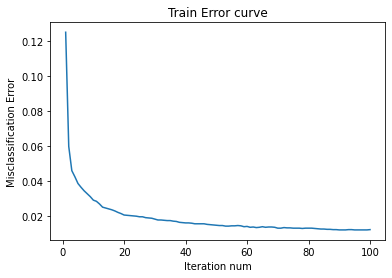

In [147]:
# Plot the train misclassifcation error vs iteration number when selecting 300 features
plt.plot([i+1 for i in range(len(model_a.train_errors_all[3]))], model_a.train_errors_all[3])
#plt.plot([i+1 for i in range(len(model_a.test_errors_all[3]))], model_a.test_errors_all[3])
plt.title("Train Error curve")
plt.xlabel("Iteration num")
plt.ylabel("Misclassification Error")
plt.show()

### Output 2:
Plot the final train and test misclassification error vs the number of selected features

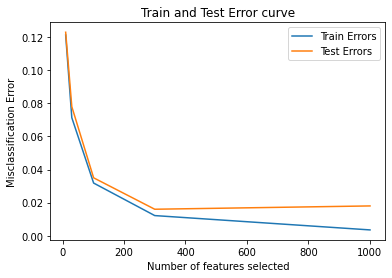

In [129]:
# Plot the train and test misclassifcation error vs number of selected features
plt.plot(model_a.num_features, model_a.train_errors_final)
plt.plot(model_a.num_features, model_a.test_errors_final)


plt.title("Train and Test Error curve")
plt.xlabel("Number of features selected")
plt.ylabel("Misclassification Error")
plt.legend(['Train Errors', 'Test Errors'])
plt.show()

### Output 3:
Report in a table:
- The misclassification errors on the training and test set
- The correspoing numbers of selected features 
- The values of $\lambda$

In [130]:
info_a = {"Train Error": model_a.train_errors_final, 
          "Test Error": model_a.test_errors_final,
          "Number of Features": model_a.num_features, 
          "Lambda": model_a.lambdas}

df_a = pd.DataFrame(info_a)
df_a

,Train Error,Test Error,Number of Features,Lambda
0,0.121333,0.123,10,0.1900
1,0.071333,0.078,30,0.1330
2,0.031833,0.035,101,0.0875
3,0.012167,0.016,300,0.0529
4,0.003500,0.018,1001,0.0180


## Problem 1.b:

In [131]:
# Data input
X_train_b = pd.read_csv('data/dexter/dexter_train.csv', sep=',', header=None, nrows=300)
y_train_b = pd.read_csv('data/dexter/dexter_train.labels', header=None, nrows=300)

X_test_b = pd.read_csv('data/dexter/dexter_valid.csv', sep=',', header=None, nrows=300)
y_test_b = pd.read_csv('data/dexter/dexter_valid.labels', header=None, nrows=300)

# Prepare data for matrix algebra
y_train_b = y_train_b.values.ravel()
y_test_b = y_test_b.values.ravel()

In [132]:
# Normalize the variables of the training set
scaler_b = StandardScaler()
scaler_b.fit(X_train_b)

StandardScaler()

In [133]:
# Transform both the train and test set
X_train_scaled_b = scaler_b.transform(X_train_b)
X_test_scaled_b = scaler_b.transform(X_test_b)

In [134]:
# Initialize TISP model and fit to data
'''
Manually captured lambdas:

(Feature, Lambda) = (1000, 0.03993), (299, 0.05227), 
                    (100, 0.07112), (30, 0.098), (11, 0.1427)
                    
'''
lambdas_b = [0.03993, 0.05227,0.07112, 0.098, 0.1427]
lambdas_b.reverse()

model_b = TISP(lambdas = lambdas_b)
model_b.fit(X_train_scaled_b, y_train_b, X_test_scaled_b, y_test_b)

### Output 1:
Plot the train misclassification error vs iteration number when selecting 300 features

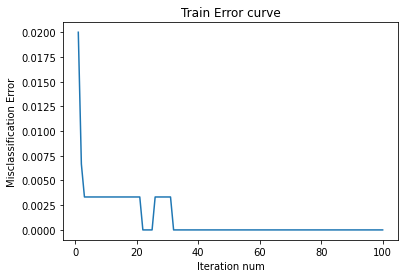

In [135]:
# Plot the train misclassifcation error vs iteration number when selecting 300 features
plt.plot([i+1 for i in range(len(model_b.train_errors_all[3]))], model_b.train_errors_all[3])
#plt.plot([i+1 for i in range(len(model_b.test_errors_all[3]))], model_b.test_errors_all[3])
plt.title("Train Error curve")
plt.xlabel("Iteration num")
plt.ylabel("Misclassification Error")
plt.show()

### Output 2:
Plot the final train and test misclassification error vs the number of selected features

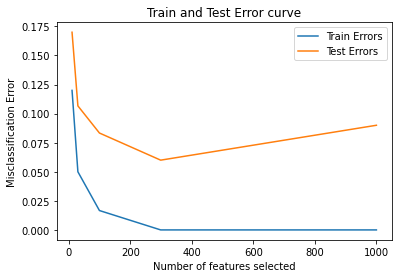

In [136]:
# Plot the train and test misclassifcation error vs number of selected features
plt.plot(model_b.num_features, model_b.train_errors_final)
plt.plot(model_b.num_features, model_b.test_errors_final)


plt.title("Train and Test Error curve")
plt.xlabel("Number of features selected")
plt.ylabel("Misclassification Error")
plt.legend(['Train Errors', 'Test Errors'])
plt.show()

### Output 3:
Report in a table:
- The misclassification errors on the training and test set
- The correspoing numbers of selected features 
- The values of $\lambda$

In [137]:
info_b = {"Train Error": model_b.train_errors_final, 
          "Test Error": model_b.test_errors_final,
          "Number of Features": model_b.num_features, 
          "Lambda": model_b.lambdas}

df_b = pd.DataFrame(info_b)
df_b

,Train Error,Test Error,Number of Features,Lambda
0,0.120000,0.170000,11,0.14270
1,0.050000,0.106667,30,0.09800
2,0.016667,0.083333,100,0.07112
3,0.000000,0.060000,299,0.05227
4,0.000000,0.090000,1000,0.03993


# Problem 1.c:

In [138]:
# Madelon data input
X_train_c = pd.read_csv("data/MADELON/madelon_train.data", sep='\s+', header=None)
y_train_c = pd.read_csv("data/MADELON/madelon_train.labels", sep=' ', header=None)

X_test_c = pd.read_csv("data/MADELON/madelon_valid.data", sep='\s+', header=None)
y_test_c = pd.read_csv("data/MADELON/madelon_valid.labels", sep=' ', header=None)

# Prepare data for matrix algebra
y_train_c = y_train_c.values.ravel()
y_test_c = y_test_c.values.ravel()

In [139]:
# Normalize the variables of the training set
scaler_c = StandardScaler()
scaler_c.fit(X_train_c)

StandardScaler()

In [140]:
# Transform both the train and test set
X_train_scaled_c = scaler_c.transform(X_train_c)
X_test_scaled_c = scaler_c.transform(X_test_c)

In [141]:
# Initialize TISP model and fit to data
'''
Manually captured lambdas:

(Feature, Lambda) = (500, 0.000042), (302, 0.00737), 
                    (100, 0.0173), (30, 0.02435), (8, 0.0298)
                    
'''
#lambdas_c = [0.0298]

lambdas_c = [0.000042, 0.00737, 0.0173, 0.02435, 0.0298]
lambdas_c.reverse()

model_c = TISP(lambdas = lambdas_c)
model_c.fit(X_train_scaled_c, y_train_c, X_test_scaled_c, y_test_c)

### Output 1:
Plot the train misclassification error vs iteration number when selecting 300 features

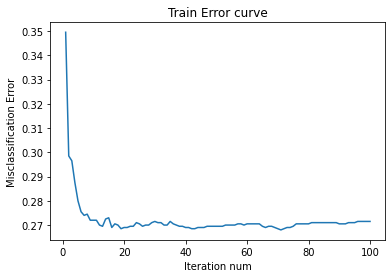

In [142]:
# Plot the train misclassifcation error vs iteration number when selecting 300 features
plt.plot([i+1 for i in range(len(model_c.train_errors_all[3]))], model_c.train_errors_all[3])
#plt.plot([i+1 for i in range(len(model_c.test_errors_all[3]))], model_c.test_errors_all[3])
plt.title("Train Error curve")
plt.xlabel("Iteration num")
plt.ylabel("Misclassification Error")
plt.show()

### Output 2:
Plot the final train and test misclassification error vs the number of selected features

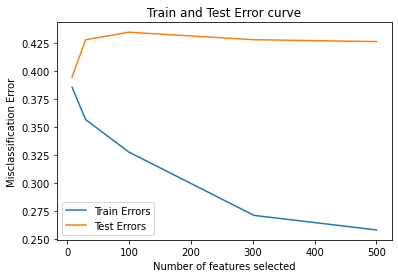

In [144]:
# Plot the train and test misclassifcation error vs number of selected features
plt.plot(model_c.num_features, model_c.train_errors_final)
plt.plot(model_c.num_features, model_c.test_errors_final)


plt.title("Train and Test Error curve")
plt.xlabel("Number of features selected")
plt.ylabel("Misclassification Error")
plt.legend(['Train Errors', 'Test Errors'])
plt.show()

### Output 3:
Report in a table:
- The misclassification errors on the training and test set
- The correspoing numbers of selected features 
- The values of $\lambda$

In [145]:
info_c = {"Train Error": model_c.train_errors_final, 
          "Test Error": model_c.test_errors_final,
          "Number of Features": model_c.num_features, 
          "Lambda": model_c.lambdas}

df_c = pd.DataFrame(info_c)
df_c

,Train Error,Test Error,Number of Features,Lambda
0,0.3860,0.395000,8,0.029800
1,0.3570,0.428333,30,0.024350
2,0.3280,0.435000,100,0.017300
3,0.2715,0.428333,302,0.007370
4,0.2585,0.426667,500,0.000042
